1031
4096
4096
4096


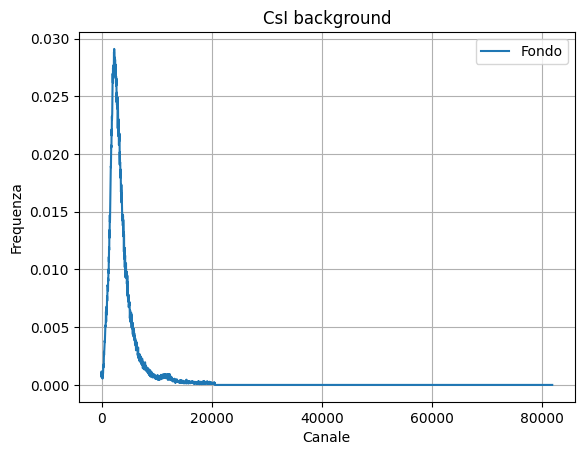

In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Caratterizzazione Cristalli\CsI\Fondo CsI\Misura di fondo CSI.CSV', sep=';')
data1 = pd.read_csv(r'C:\Users\Black\Desktop\Esperimentazioni di Nucleare e Subnucleare\SiPM\Caratterizzazione Cristalli\CsI\Sodio\SpettroNa_2ndRun_300s.csv', sep=' \t', engine='python')

print(len(data['Channel']))
print(len(data1['Channel']))

channel_back = np.array(data['Channel']) #taglio i dati per avere lo stesso numero di elementi
counts_back = np.array(data['Counts'])
time_back = 61638 #s
frequency_back = counts_back/time_back

channel_Na = np.array(data1['Channel'])
counts_Na = np.array(data1['Counts'])
time_Na = 300 #s
frequency_Na = counts_Na/time_Na

# devo allungare il fondo con tanti zeri
allungo_x = np.arange(20510, 81800, 20)
allungo_y = np.zeros(len(allungo_x))
channel_back = np.concatenate((channel_back, allungo_x))
frequency_back = np.concatenate((frequency_back, allungo_y))

print(len(channel_back))
print(len(channel_Na))

plt.plot(channel_back, frequency_back, label='Fondo')
plt.xlabel('Canale')
plt.ylabel('Frequenza')
plt.title('CsI background')
plt.legend()
plt.grid()
plt.show()

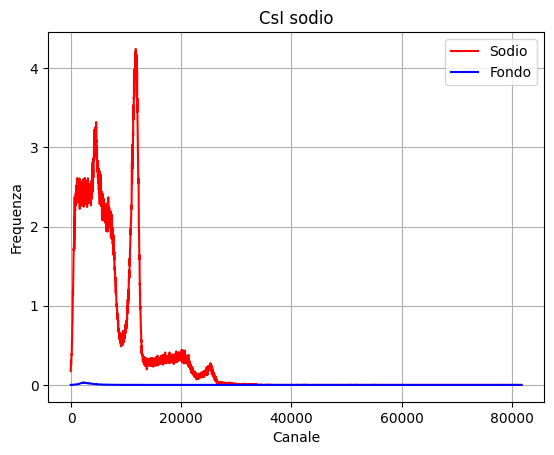

In [16]:
plt.plot(channel_Na, frequency_Na, label='Sodio', color='red', marker='', linestyle='-')
plt.plot(channel_back, frequency_back, label='Fondo', color='blue', marker='', linestyle='-')
plt.xlabel('Canale')
plt.ylabel('Frequenza')
plt.title('CsI sodio')
plt.legend()
plt.grid()

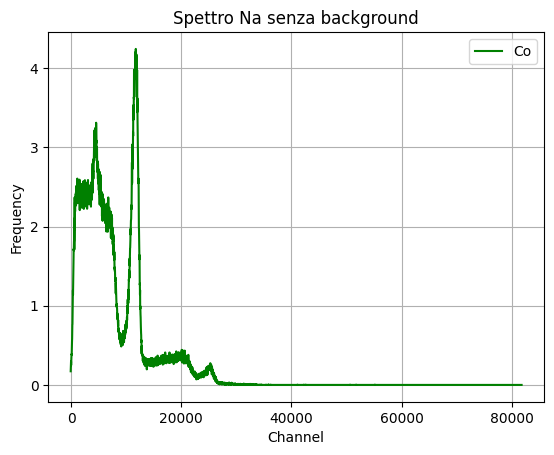

In [17]:
channel = channel_back
frequency = frequency_Na - frequency_back

for i in range(len(frequency)):
    if frequency[i] < 0:
        frequency[i] = 0

plt.plot(channel, frequency, marker='', linestyle='-', color='green', label='Co')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.legend()
plt.title('Spettro Na senza background')
plt.grid()

import plotly.express as px
fig = px.line(x=channel, y=frequency, title='Spettro Na senza background')
fig.show()

In [18]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import norm, chi2


def repeat_fit(ls, left_bound, right_bound, mu, sigma, A, ampiezza_picco_limite, dis=False, limit_ADC=100):
    '''
    ampiezza picco limite = è la ampiezza dell'intorno di mu in cui è accettabile avere il picco
    '''
    peak_list = []
    error_peak_list = []
    sigma_list = []
    error_sigma_list = []
    for delta_ADC in np.arange(0, abs(right_bound-left_bound)/2+limit_ADC, 10):
        ls.mask = (channel > left_bound+delta_ADC) & (channel < right_bound-delta_ADC)
        m = Minuit(ls, mu=mu, sigma=sigma, A=A)
        m.migrad()
        m.hesse()
        p_value = (1. - chi2.cdf (m.fval, df = m.ndof))
        if p_value > 0.05 and m.valid == True:
            if m.values['mu'] < (mu+ampiezza_picco_limite/2) and m.values['mu'] > (mu-ampiezza_picco_limite/2):    
                peak_list.append(m.values['mu'])
                error_peak_list.append(m.errors['mu'])
                sigma_list.append(m.values['sigma'])
                error_sigma_list.append(m.errors['sigma'])
                if dis==True: display(m)
        ls.mask = None
    for delta_ADC in np.arange(0, abs(right_bound-left_bound)/2+limit_ADC, 10):
        ls.mask = (channel > left_bound+delta_ADC) & (channel < right_bound-delta_ADC/2)
        m = Minuit(ls, mu=mu, sigma=sigma, A=A)
        m.migrad()
        m.hesse()
        p_value = (1. - chi2.cdf (m.fval, df = m.ndof))
        if p_value > 0.05 and m.valid == True:
            if m.values['mu'] < (mu+ampiezza_picco_limite/2) and m.values['mu'] > (mu-ampiezza_picco_limite/2):    
                peak_list.append(m.values['mu'])
                error_peak_list.append(m.errors['mu'])
                sigma_list.append(m.values['sigma'])
                error_sigma_list.append(m.errors['sigma'])
                if dis==True: display(m)
        ls.mask = None
    for delta_ADC in np.arange(0, abs(right_bound-left_bound)/2+limit_ADC, 10):
        ls.mask = (channel > left_bound+delta_ADC/2) & (channel < right_bound-delta_ADC)
        m = Minuit(ls, mu=mu, sigma=sigma, A=A)
        m.migrad()
        m.hesse()
        p_value = (1. - chi2.cdf (m.fval, df = m.ndof))
        if p_value > 0.05 and m.valid == True:
            if m.values['mu'] < (mu+ampiezza_picco_limite/2) and m.values['mu'] > (mu-ampiezza_picco_limite/2):    
                peak_list.append(m.values['mu'])
                error_peak_list.append(m.errors['mu'])
                sigma_list.append(m.values['sigma'])
                error_sigma_list.append(m.errors['sigma'])
                if dis==True: display(m)
        ls.mask = None
    return np.array(peak_list), np.array(error_peak_list), np.array(sigma_list), np.array(error_sigma_list)

In [19]:
def func(x, mu, sigma, A):
    return A * norm.pdf(x, mu, sigma)

error = np.sqrt(counts_Na)/time_Na

ls = LeastSquares(channel, frequency, error, func)

peak_list511, error_peak_list511, sigma_list511, err_sigma_list511 = repeat_fit(ls, 10000, 12500, 11750, 500, 4, 100)

print(peak_list511)
print(error_peak_list511)

[11715.03465096 11709.45274143 11709.45274143 11704.24654338
 11716.12955873 11724.62207833 11724.45425696 11724.45425696
 11732.55972516 11713.76978228 11713.76978228 11722.06789268
 11747.57530825 11741.95478077 11709.54248725 11709.54248725
 11709.70382422]
[18.68960189 17.46659739 17.46659739 16.2347077  20.86975944 25.03173714
 25.43133519 25.43133519 29.16201347 27.98961938 27.98961938 32.80265001
 47.20534995 46.7551202  37.88763856 37.88763856 43.99078286]


In [20]:
peak_list1274_5, error_peak_list1274_5, sigma_list1274_5, err_sigma_list1274_5 = repeat_fit(ls, 25000, 25600, 25260, 600, 0.2, 150, dis=False, limit_ADC=200)

print(peak_list1274_5)
print(error_peak_list1274_5)

[25247.2529381  25256.88082402 25256.88082402 25250.13846834
 25250.13846834 25250.55394694 25250.55394694 25245.38238634
 25245.38238634 25275.2577873  25275.2577873  25247.2529381
 25255.60837677 25256.88082402 25249.99379285 25249.99379285
 25245.54404774 25250.19922964 25263.29052552 25215.45078739
 25255.25240002 25255.25240002 25247.2529381  25248.70618073
 25256.88082402 25252.93610603 25252.93610603 25251.42619574
 25249.65264668 25259.31433277 25259.31433277 25250.7347282
 25250.7347282  25247.88448259 25262.24523412 25256.3686117
 25256.3686117  25242.67623027 25247.55046057 25247.55046057
 25237.95302969 25251.68097174 25239.93012042 25239.74401072
 25263.57826513 25246.15038113 25283.53683669 25283.53683669
 25231.63074508]
[ 25.15205035  27.29974896  27.29974896  26.61103403  26.61103403
  28.23452337  28.23452337  78.01135985  78.01135985  37.10222141
  37.10222141  25.15205035  24.73057044  27.29974896  34.69604089
  34.69604089  43.06180419  30.63192379  42.8288035  174

In [21]:
def weighted_mean(values, errors):
    mean = np.sum(values/(errors**2))/np.sum(1/(errors**2))
    error_mean = np.sqrt((abs(np.max(values) - np.min(values))/2)**2 + (1/np.sum(1/(errors**2))))
    return mean, error_mean

# first peak at 511 KeV
mean511, error_mean511 = weighted_mean(peak_list511, error_peak_list511)
print(mean511, error_mean511)

# second peak at 1274.5 KeV
mean1274_5, error_mean1274_5 = weighted_mean(peak_list1274_5, error_peak_list1274_5)
print(mean1274_5, error_mean1274_5)

'''
# plot di entrambi i fit sopra i dati totali
x1 = np.linspace(11300, 12500, 5000)
x2 = np.linspace(24750, 25750, 5000)
Y1 = func(x1, *m1.values)
Y2 = func(x2, *m2.values)
plt.plot(x1, Y1, label='511 KeV', color='orange')
plt.plot(x2, Y2, label='1274.5 KeV', color='purple')
plt.errorbar(channel, frequency, error, fmt='', label='data', alpha=0.2, color='blue', ecolor='blue')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.title('CsI spectrum')
plt.grid()
plt.legend()
plt.show()
'''

11715.390443444863 22.482972508264023
25249.424621258895 34.281599393558515


"\n# plot di entrambi i fit sopra i dati totali\nx1 = np.linspace(11300, 12500, 5000)\nx2 = np.linspace(24750, 25750, 5000)\nY1 = func(x1, *m1.values)\nY2 = func(x2, *m2.values)\nplt.plot(x1, Y1, label='511 KeV', color='orange')\nplt.plot(x2, Y2, label='1274.5 KeV', color='purple')\nplt.errorbar(channel, frequency, error, fmt='', label='data', alpha=0.2, color='blue', ecolor='blue')\nplt.xlabel('Channel')\nplt.ylabel('Frequency')\nplt.title('CsI spectrum')\nplt.grid()\nplt.legend()\nplt.show()\n"

In [22]:
picchi1 = np.array([429.96874270511046, 3333.3858987743347, 7185.859260584772, mean511, mean1274_5, 35284.64923506494])
err_picchi1 = np.array([19.687008690946804, 10, 108.41437094685955, error_mean511, error_mean1274_5, 393.4152195973929])
energia1 = np.array([14.4, 122.1, 300.1, 511, 1274.5, 2104])

def line(x, m, q):
    return m*x + q

ls3 = LeastSquares(energia1, picchi1, err_picchi1, line)
m3 = Minuit(ls3, m=1, q=0)
m3.migrad()
m3.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3359 (χ²/ndof = 839.8)     │              Nfcn = 41               │
│ EDM = 2.84e-18 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │  19.729   │   0.027   │            │            │         │         │       │
│ 1 │ q    │    839    │    10     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         m         q │
├───┼─────────────────────┤
│ m │  0.000745 -163.1e-3 │
│ q │ -163.1e-3       100 │
└───┴─────────────────────┘

In [23]:
def parabola(x, a, x0, y0):
    return y0 + a*(x-x0)**2

ls4 = LeastSquares(energia1, picchi1, err_picchi1, parabola)
m4 = Minuit(ls4, a=-1, x0=2500, y0=25000)
m4.migrad()
m4.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 242.2 (χ²/ndof = 80.7)     │              Nfcn = 462              │
│ EDM = 1.43e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ -3.94e-3  │  0.07e-3  │            │            │         │         │       │
│ 1 │ x0   │  3.12e3   │  0.05e3   │            │            │         │         │       │
│ 2 │ y0   │  38.6e3   │   0.4e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────────────────┐
│    │            a           x0           y0 │
├────┼────────────────────────────────────────┤
│  a │     5.09e-09  3.235389e-3 30.679013e-3 │
│ x0 │  3.235389e-3     2.07e+03       19.8e3 │
│ y0 │ 30.679013e-3       19.8e3     1.91e+05 │
└────┴────────────────────────────────────────┘

In [24]:
def func1(x, a, b):
    return b*(1 - np.exp(-a*x))

ls5 = LeastSquares(energia1, picchi1, err_picchi1, func1)
m5 = Minuit(ls5, a=0.001, b=25000)
m5.migrad()
m5.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 517.7 (χ²/ndof = 129.4)    │              Nfcn = 113              │
│ EDM = 6.42e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  507e-6   │   5e-6    │            │            │         │         │       │
│ 1 │ b    │  52.8e3   │   0.4e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────┐
│   │               a               b │
├───┼─────────────────────────────────┤
│ a │        2.86e-11 -2.353433616e-3 │
│ b │ -2.353433616e-3        1.97e+05 │
└───┴─────────────────────────────────┘

[14.4, 122.1, 300.1, 511.0, 1274.5, 2104.0]
[429.96874270511046, 3333.3858987743347, 7185.859260584772, 11715.390443444863, 25249.424621258895, 35284.64923506494]
[19.687008690946804, 10.0, 108.41437094685955, 22.482972508264023, 34.281599393558515, 393.4152195973929
parametri espontenziale: <ValueView a=0.0005067873725051194 b=52804.4887695497>


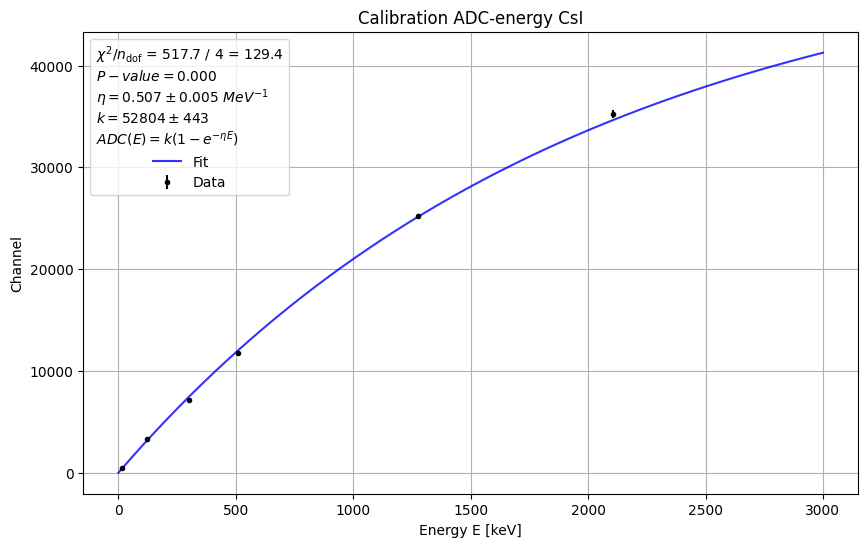

In [25]:
# plot dell'esponenziale e della parabola sovrapposti

x = np.linspace(0, 3000, 1000)
y = func1(x, *m5.values)

plt.subplots(figsize=(10, 6))
plt.plot(x, y, label='Fit', color='blue', alpha=0.8)

plt.errorbar(energia1, picchi1, err_picchi1, fmt='.', linestyle='', label='Data', color='black')
print(f'[{energia1[0]}, {energia1[1]}, {energia1[2]}, {energia1[3]}, {energia1[4]}, {energia1[5]}]')
print(f'[{picchi1[0]}, {picchi1[1]}, {picchi1[2]}, {picchi1[3]}, {picchi1[4]}, {picchi1[5]}]')
print(f'[{err_picchi1[0]}, {err_picchi1[1]}, {err_picchi1[2]}, {err_picchi1[3]}, {err_picchi1[4]}, {err_picchi1[5]}')

p_value = (1. - chi2.cdf(m5.fval, df=m5.ndof))


fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m5.fval:.1f} / {m5.ndof:.0f} = {m5.fval/m5.ndof:.1f}",]
fit_info.append(f"$P-value = {p_value:.3f}$")
fit_info.append(f"$\eta = {m5.values['a']*10**3:.3f} \pm {m5.errors['a']*10**3:.3f}$"+" $MeV^{-1}$")
fit_info.append(f"$k = {m5.values['b']:.0f} \pm {m5.errors['b']:.0f}$")
fit_info.append(r"$ADC(E) = k(1-e^{-\eta E})$")

plt.xlabel('Energy E [keV]')
plt.ylabel('Channel')
plt.title('Calibration ADC-energy CsI')
plt.grid()
plt.legend(title="\n".join(fit_info), frameon=True)
plt.savefig('calibrazione_CsI.png')

print(f'parametri espontenziale: {m5.values}')

In [26]:
# estrapolazione energie dai picchi del fondo del CsI

import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter(x=channel_back, y=frequency_back, mode='lines', name='Fondo CsI')])
fig.show()

def parabola(x, a, x0, y0):
    return y0 + a*(x-x0)**2

error = np.sqrt(counts_back)/time_back
error = np.concatenate((error, np.zeros(len(allungo_x))))

ls = LeastSquares(channel_back, frequency_back, error, parabola)
m = Minuit(ls, a=-1, x0=2250, y0=np.max(frequency_back))
ls.mask = (channel_back > 1900) & (channel_back < 2700)
m.migrad()
m.hesse()
display(m)

def energy(x, k, eta):
    return -np.log(1 - x/k)/eta

def err_energy(x, err_x, k, eta, err_k, err_eta):
    return np.sqrt((err_eta/eta**2 * np.log(1-x/k))**2 + (x/(eta*k**2)/(1-x/k))**2 * err_k**2 + (err_x/(k*eta*(1-x/k)))**2)

ADC_peak = m.values['x0']
ADC_error = m.errors['x0']

energy_peak = energy(ADC_peak, m5.values['b'], m5.values['a'])
error_energy_peak = err_energy(ADC_peak, ADC_error, m5.values['b'], m5.values['a'], m5.errors['b'], m5.errors['a'])

print(f'energia picco: {energy_peak} +- {error_energy_peak}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 29.92 (χ²/ndof = 0.8)      │              Nfcn = 109              │
│ EDM = 1.4 (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ -18.4e-9  │  2.2e-9   │            │            │         │         │       │
│ 1 │ x0   │  2.288e3  │  0.012e3  │            │            │         │         │       │
│ 2 │ y0   │ 27.95e-3  │  0.16e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────┐
│    │               a              x0              y0 │
├────┼─────────────────────────────────────────────────┤
│  a │        4.94e-18 -6.973650025e-9    -269.071e-15 │
│ x0 │ -6.973650025e-9             157      314.057e-6 │
│ y0 │    -269.071e-15      314.057e-6        2.56e-08 │
└────┴─────────────────────────────────────────────────┘

energia picco: 87.39616003471453 +- 1.2857992905951254


In [27]:
# RISOLUZIONE ENERGETICA

sigma_511, err_sigma_511 = weighted_mean(sigma_list511, err_sigma_list511)
sigma_1274_5, err_sigma_1274_5 = weighted_mean(sigma_list1274_5, err_sigma_list1274_5)

print(sigma_511, err_sigma_511)
print(sigma_1274_5, err_sigma_1274_5)

sigma = np.array([197.67785609543995, 235.71071366579994, 393.9075285470078, sigma_511, sigma_1274_5, 843.1607460823968]) 
err_sigma = np.array([31.096238135292676, 22.557882232684015, 97.60687970362159, err_sigma_511, err_sigma_1274_5, 442.4166363350772])

R = 2.35 * sigma/picchi1
err_R = 2.35 * np.sqrt((err_sigma/picchi1)**2 + (sigma*err_picchi1/picchi1**2)**2)
print(R)
print(err_R)

# fit esponenziale
def exp_R(x, k, q):
    return k/np.sqrt(x) + q

ls6 = LeastSquares(energia1, R, err_R, exp_R)
m6 = Minuit(ls6, k=1, q=1)
m6.migrad()
m6.hesse()
display(m6)

'''
xaxis = np.linspace(0.8, 1300, 1000)
yaxis = exp_R(xaxis, *m6.values)
plt.plot(xaxis, yaxis, label='Fit esponenziale', color='red')
plt.errorbar(energia1, R, err_R, fmt='.', linestyle='', color='black')
plt.xlabel('Energia [KeV]')
plt.ylabel('Risoluzione energetica')
plt.legend()
plt.title('Risoluzione energetica CsI')
plt.grid()
'''

684.9412270638344 56.677266770222396
305.2424187958633 230.27843650951522
[1.08041101 0.16617343 0.12882004 0.13739294 0.02840935 0.05615552]
[0.17700994 0.01591087 0.03197961 0.011372   0.02143238 0.02947213]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 25.31 (χ²/ndof = 6.3)      │              Nfcn = 40               │
│ EDM = 1e-22 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ k    │   1.93    │   0.32    │            │            │         │         │       │
│ 1 │ q    │   0.023   │   0.018   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        k        q │
├───┼───────────────────┤
│ k │   0.0994 -5.27e-3 │
│ q │ -5.27e-3 0.000342 │
└───┴───────────────────┘

"\nxaxis = np.linspace(0.8, 1300, 1000)\nyaxis = exp_R(xaxis, *m6.values)\nplt.plot(xaxis, yaxis, label='Fit esponenziale', color='red')\nplt.errorbar(energia1, R, err_R, fmt='.', linestyle='', color='black')\nplt.xlabel('Energia [KeV]')\nplt.ylabel('Risoluzione energetica')\nplt.legend()\nplt.title('Risoluzione energetica CsI')\nplt.grid()\n"

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 23.85 (χ²/ndof = 6.0)      │              Nfcn = 63               │
│ EDM = 1.36e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    90     │    60     │            │            │         │         │       │
│ 1 │ b    │    4.5    │    0.7    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 3.4e+03   -22.1 │
│ b │   -22.1   0.513 │
└───┴─────────────────┘

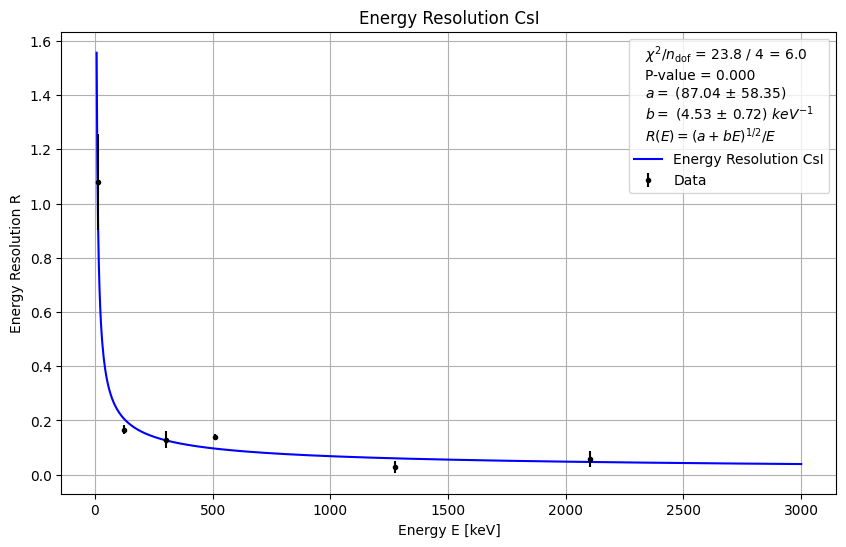

[a, b] = [87.03850964370892, 4.527355308595465]
[1.0804110059295307, 0.1661734326404581, 0.1288200420460417, 0.13739293550396697, 0.02840934773485204, 0.05615551794474246]
[0.17700994128423367, 0.01591086769444574, 0.031979605408511656, 0.011371997635210504, 0.02143237758072391, 0.0294721306757633]


In [28]:
def Knoll_func(x, a, b):
    return np.sqrt(a+b*x)/x

ls7 = LeastSquares(energia1, R, err_R, Knoll_func)
m7 = Minuit(ls7, a=1, b=1)
m7.migrad()
m7.hesse()
display(m7)

plt.subplots(figsize=(10, 6))
xaxis = np.linspace(7, 3000, 1000)
yaxis = Knoll_func(xaxis, *m7.values)
plt.plot(xaxis, yaxis, label='Energy Resolution CsI', color='blue')
plt.errorbar(energia1, R, err_R, fmt='.', linestyle='', color='black', label='Data')
plt.xlabel('Energy E [keV]')
plt.ylabel('Energy Resolution R')

fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m7.fval:.1f} / {m7.ndof:.0f} = {m7.fval/m7.ndof:.1f}",]
p_value = (1. - chi2.cdf(m7.fval, df=m7.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
fit_info.append('$a = $ ({0:.2f} $\\pm$ {1:.2f})'.format(m7.values['a'], m7.errors['a']))
fit_info.append('$b = $ ({0:.2f} $\\pm$ {1:.2f})'.format(m7.values['b'], m7.errors['b']) + ' $keV^{-1}$')
fit_info.append(r'$R(E) = (a+bE)^{1/2}/E$')
plt.legend(title="\n".join(fit_info), frameon=True)

plt.title('Energy Resolution CsI')
plt.grid()
plt.savefig('risoluzione_energetica_CsI.png')
plt.show()

print(f'[a, b] = [{m7.values["a"]}, {m7.values["b"]}]')
print(f'[{R[0]}, {R[1]}, {R[2]}, {R[3]}, {R[4]}, {R[5]}]')
print(f'[{err_R[0]}, {err_R[1]}, {err_R[2]}, {err_R[3]}, {err_R[4]}, {err_R[5]}]')